## Import required modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage import data
import skimage
from skimage.filters.thresholding import threshold_li,threshold_local,threshold_otsu, threshold_yen
from skimage.morphology import erosion, dilation, opening, closing, white_tophat, remove_small_objects, ball
from skimage.morphology import disk
from scipy import ndimage as ndi
import sys,os, glob

#import skimage.filters.median

#import skimage.segmentation as seg
#import skimage.filters as filters
#import skimage.draw as draw
#import skimage.color as color

#from skimage.filters.thresholding import _cross_entropy
#from skimage.morphology import black_tophat, skeletonize, convex_hull_image


#pip install nd2reader_required for nd2 file reading
from nd2reader import ND2Reader

import pandas as pd

# for dna segmentation
import cellpose
from cellpose import models

c:\programdata\anaconda3\lib\site-packages\skimage\io\manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


## Load data to analyze

### 1. Load images

In [2]:
# Define data loading and saving folder

# path to glob
data_save_folder = r"D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\*"

# path to save results
data_main_folder = r"D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B"

# not used here
analysis_prefix = 'Lac_Ms2'
############################# CHANGE WELL FOR DATA OF INTEREST HERE!##########################################


data_folder = data_save_folder
#data_files = [file for file in glob.glob(data_folder) if "z2.tif" in file]
data_files = [file for file in glob.glob(data_folder) if "nd" in file]
data_files



# load cell info for analysis

cell_name = 'control_1'


### 2. Cropp and saved cropped images 

In [3]:
#%matplotlib notebook
#image_test =np.array(images.get_frame_2D (v=0, c=0, z=1))
#plt.imshow(image_test)

In [4]:
# load images and get data name for the nd2 file
images = ND2Reader(data_files[0])
data_name = data_files[0].split('\\')[-1].split('.nd2')[0]

#images.sizes["t"]
# define the cropping coord inverted (input number are xy as seen in ImageJ)
#crop_x1, crop_x2, crop_y1, crop_y2 = 756,1146,819,1089 # x1-2, then y1-2


crop_x1, crop_x2, crop_y1, crop_y2 = 176,718,8,473

# z for analyze
z_selected = 2

#save cropped images or not
# ch-t-z-xy
_save_crop_image =True

if _save_crop_image:
    crop_image_ch_all = {}

    for ind, ch in enumerate(range(images.sizes["c"])):
        image_ch_all = []
    
        for timepoint in range(images.sizes["t"]):
            image_ch =np.array(images.get_frame_2D (v=timepoint, c=ch, z=z_selected))[crop_y1: crop_y2, crop_x1: crop_x2]
        
        #for _lyr in range(images.sizes["z"]):
            #lyr_ch = np.array(images.get_frame_2D (v=timepoint, c=ch, z=_lyr))[840:1200,850:1250]
            #image_ch.append(lyr_ch)
            
            image_ch_all.append(image_ch)
        
        crop_image_ch_all[ind] = np.array(image_ch_all)    

    raw_cell_path = data_main_folder + os.sep + f'raw_{cell_name}'
    if not os.path.exists(raw_cell_path):
        os.mkdir(raw_cell_path)

    savename_list = [raw_cell_path + os.sep + f'{data_name}_{cell_name}_DNA.tif',
                   raw_cell_path + os.sep + f'{data_name}_{cell_name}_lac.tif',
                   raw_cell_path + os.sep + f'{data_name}_{cell_name}_ms2.tif']

    for ind, save_name in enumerate(savename_list):
        if os.path.exists(save_name):
            os.remove(save_name)
        io.imsave(save_name, crop_image_ch_all[ind])

C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:47: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\raw_control_1\210909_263_5B_control_1_DNA.tif is a low contrast image
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:47: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\raw_control_1\210909_263_5B_control_1_lac.tif is a low contrast image
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:47: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\raw_control_1\210909_263_5B_control_1_ms2.tif is a low contrast image


### 3. Other parameters and cell info

In [5]:
# Define some shared parameters here

# the dilation for measuring the foci
_foci_measure_size = 2

nuclei_filter = 600
foci_filter = 10

use_STD_foci_segmentation = False



In [6]:
# load cell info for analysis


cell_info = pd.read_excel(data_main_folder + os.sep + f'{data_name}_cell_info_{cell_name}.xlsx')

cell_info

,timepoint,cell X,cell Y,cell area,lac X,lac Y,stage
0,1,344.0,157.0,7000.0,282.0,145.0,1
1,16,NaN,NaN,NaN,NaN,NaN,m
2,20,270.0,198.0,7000.0,237.0,178.0,2


In [7]:
# Define timepoints duration based on cell info

_all_time_points = range(images.sizes["t"])

_first_duration = range(int(cell_info[cell_info['stage'] == 1]['timepoint'])-1,
                        int(cell_info[cell_info['stage'] == 'm']['timepoint'])-1)

_mitosis_duration = range(int(cell_info[cell_info['stage'] == 'm']['timepoint']-1),
                        int(cell_info[cell_info['stage'] == 2]['timepoint'])-1)

_second_duration = range(int(cell_info[cell_info['stage'] == 2]['timepoint'])-1,
                        images.sizes["t"])

if len(cell_info[cell_info['stage'] == 'e'])>0:
    _end_time_point = int(cell_info[cell_info['stage'] == 'e']['timepoint'])-1

    if _end_time_point >0 and _end_time_point <images.sizes["t"]:
        _all_time_points = range(0, _end_time_point)
        
if len(cell_info[cell_info['stage'] == 's'])>0:
    _skip_time_points =  []
    for _t in cell_info[cell_info['stage'] == 's']['timepoint']:
        _skip_time_points.append(int(_t)-1)
    
    _all_time_points = [_t for _t in _all_time_points if _t not in _skip_time_points]

#_first_duration
#_mitosis_duration
#_second_duration


# Define cell centorid, etc., for annotated timepoints based on cell info

annotated_timepoints = {}


for _item in cell_info.iloc():
    
    annotated_timepoints[_item['timepoint']] = {}
    annotated_timepoints[_item['timepoint']]['cell_centroid']=[_item['cell X'],_item['cell Y']]
    annotated_timepoints[_item['timepoint']]['cell_area']=_item['cell area']
    annotated_timepoints[_item['timepoint']]['foci_centroid']=[_item['lac X'],_item['lac Y']]

annotated_timepoints

{1: {'cell_centroid': [344.0, 157.0],
  'cell_area': 7000.0,
  'foci_centroid': [282.0, 145.0]},
 16: {'cell_centroid': [nan, nan],
  'cell_area': nan,
  'foci_centroid': [nan, nan]},
 20: {'cell_centroid': [270.0, 198.0],
  'cell_area': 7000.0,
  'foci_centroid': [237.0, 178.0]}}

In [8]:
_all_time_points

range(0, 89)

##  Analysis for cell of interest

### 1. Define basic function for analysis

In [9]:
def segment_and_track_object (images, ch_index,
                            object_centroid = [176,103],
                              ref_centroid = [],
                            object_area = 7000,
                            time = 0,     
                            search_dist = 600,
                            z_selected = 1,
                            nuclei_filter = 600,
                              foci_filter = 20,
                            mode = 'nuclei',
                              foci_segmentation = 'Yen',
                              cell_mask = None,
                              use_area = True,
                            crop = True,
                             crop_x1=0,crop_x2=2048,crop_y1=0,crop_y2=2048,
                             saved_object_mask =[]):

    
    
    # load 3d images for the channel and z plane selected
    image_ch = []
    for _lyr in range(images.sizes["z"]):
        lyr_ch = np.array(images.get_frame_2D (v=time, c=ch_index-1, z=_lyr))[crop_y1: crop_y2, crop_x1: crop_x2]
        image_ch.append(lyr_ch)
        
    image_ch = np.array(image_ch)

    # use cellpose for nuclei segmentation  
    if mode == 'nuclei':
     # segment DAPI and track the cell
        model= models.Cellpose(gpu=False, model_type=mode)
        
        # adjust nuclear diameter as 100
        object_masks, flows, styles, diams = model.eval(image_ch[z_selected], diameter=100, channels = [0,0],
                                         flow_threshold=0.4, do_3D=False)
    
        
        object_masks =  remove_small_objects(object_masks, nuclei_filter ,connectivity=1)
        # erosion to remove abutting micronuclei
        object_masks = erosion(object_masks, disk(20))
        object_masks = dilation(object_masks, disk(20))

    # use Yen thresholding for lac foci segmentation
    if mode == 'foci':
        if foci_segmentation == 'Yen':
            object_masks = image_ch[z_selected] > threshold_yen(image_ch[z_selected])
            # remove small less confident foci
            object_masks = dilation(object_masks)
            object_masks = remove_small_objects(object_masks,foci_filter+5)
            object_masks = skimage.measure.label(object_masks)
        elif foci_segmentation == 'STD' and cell_mask is not None:
            foci_intensity = dilation(cell_mask) * image_ch[z_selected]
            foci_intensity_filtered = foci_intensity[foci_intensity!=0]
            foci_positive_th =np.mean(foci_intensity_filtered) + np.std(foci_intensity_filtered)*3

            foci_mask = (image_ch[z_selected] > foci_positive_th)*cell_mask
            object_masks = remove_small_objects(foci_mask, foci_filter)
            
        
    # initiate search distances
    found_dist = search_dist
    combined_dist = search_dist * 5

    # all object labels higher than background
    unique_objects_id = np.unique(object_masks)[np.unique(object_masks)>0]
    
    # if has one candiadte object (currently requires dna to always have one)
    if len(unique_objects_id) >0:

        for i in unique_objects_id:
            cand_object = object_masks == i
            cand_object[cand_object>0]=1
            cand_object = np.array(cand_object)
        
            # calculate candiate object distance to the input coord (eg., from prior timepoint)
            region = skimage.measure.regionprops (skimage.measure.label(cand_object))[0]   
            _dist = round(np.linalg.norm(np.array([region.centroid[1], region.centroid[0]])
                                                    - np.array(object_centroid)))
            
             # use area
            if use_area and abs(region.area - object_area)/object_area <=0.4:
                # also use reference distance
                if len(ref_centroid) == 2:
                    _dist_ref = round(np.linalg.norm(np.array([region.centroid[1], region.centroid[0]])
                                                    - np.array(ref_centroid)))
                
                    if _dist_ref + _dist  <= combined_dist:
                        combined_dist = _dist_ref + _dist
                        kept_object = cand_object
                        
                # not using reference distance        
                else:
                    if _dist <= found_dist:  
                        found_dist = _dist
                        kept_object = cand_object   
                        
            # if not use area or area changes too variable
            else: 
                # also use reference distance
                if len(ref_centroid) == 2:
                    _dist_ref = round(np.linalg.norm(np.array([region.centroid[1], region.centroid[0]])
                                                    - np.array(ref_centroid)))
                
                    if _dist_ref + _dist  <= combined_dist:
                        combined_dist = _dist_ref + _dist
                        kept_object = cand_object
                        
                # not using reference distance                
                else:
                    if _dist <= found_dist:  
                        found_dist = _dist
                        kept_object = cand_object
        
        # if use pre-defined object mask
        if len(saved_object_mask)>0 and saved_object_mask.shape == image_ch.shape:
            kept_object = saved_object_mask
            region = skimage.measure.regionprops (skimage.measure.label(kept_object))[0]    
            found_object_centroid = [round(region.centroid[1]), round(region.centroid[0])]
            found_object_area = region.area
            found_dist = search_dist
            
        # if there is one object passing the qualification                
        elif len(kept_object) > 0:                
            region = skimage.measure.regionprops (skimage.measure.label(kept_object))[0]    
            found_object_centroid = [round(region.centroid[1]), round(region.centroid[0])]
            found_object_area = region.area

        # if no valid objects, append empty masks and return input coord (e.g., from last timepoint)
        else:
            kept_object = np.zeros(image_ch[z_selected].shape) 
            #  this results in ms2 acumulation qualitative mode
        
            found_object_centroid = object_centroid  # use prior centroid if there is transient loss
            found_object_area = object_area
            found_dist = search_dist
            
            
        
    else: # if no candiadte object for lac: eg., lac loci lost
        kept_object = np.zeros(image_ch[z_selected].shape) 
        #  this results in ms2 acumulation qualitative mode
        
        found_object_centroid = object_centroid  # use prior centroid if there is transient loss
        found_object_area = object_area
        found_dist = search_dist
        
    # return [object mask, object centroid, object area, and the min distance] 
    return [kept_object, found_object_centroid, found_object_area, found_dist]
    
    

    

### 2. Run analysis for the cell

In [10]:

# initiate measurement dict
all_measurement_timed = {}

# loop through all timepoints
for timepoint in _all_time_points[:]:
    
    # if timepoints annotaed
    if (timepoint +1) in annotated_timepoints.keys():
        
        # if cell centroid is not np.nan, use annotated cell centroid
        if annotated_timepoints[(timepoint +1)]['cell_centroid'][0]>0:
            cell_centroid = annotated_timepoints[(timepoint +1)]['cell_centroid']
            cell_centroid = [int(_coord) for _coord in cell_centroid]
        # or use prior timepoint info
        else:
            cell_centroid= cell_object_info[1]
            
        # if foci centroid is not np.nan, use annotated foci centroid
        if annotated_timepoints[(timepoint +1)]['foci_centroid'][0]>0:
            foci_centroid = annotated_timepoints[(timepoint +1)]['foci_centroid']
            foci_centroid = [int(_coord) for _coord in foci_centroid]
        # or use prior timepoint info
        else:
            foci_centroid = foci_object_info[1]
            
        
        # if area is not np.nan, use annotated cell area
        if annotated_timepoints[(timepoint +1)]['cell_area']>0:
            cell_area = annotated_timepoints[(timepoint +1)]['cell_area']
        # or use prior timepoint info
        else:
            cell_area =cell_object_info[2]
            
    # if timepoints NOT annotaed, use prior timepoint info
    else:
        cell_centroid= cell_object_info[1]
        cell_area =cell_object_info[2]
        foci_centroid = foci_object_info[1]
            
          
    print (f'-- tracking cell at timepoint {timepoint}.') 
    print ('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
    
    # track and locate cell of interest
    cell_object_info = segment_and_track_object(images, 1,
                                                time = timepoint, 
                                                object_centroid=cell_centroid,
                                                object_area =cell_area, mode ='nuclei',
                                                z_selected = z_selected,
                                               crop_x1=crop_x1,crop_x2=crop_x2,crop_y1=crop_y1,crop_y2=crop_y2)
    
    
    # if foci centorid is anntoated for THIS timepoint, just use the foci centroid for foci tracking
    if (timepoint +1) in annotated_timepoints.keys() and annotated_timepoints[(timepoint +1)]['foci_centroid'][0]>0:
        ref_centroid = []
    # otherwise, use the found cell centroid as ref centroid to assist foci tracking;
    # where both the found cell centroid and the prior foci centorid are considered
    else:    
        ref_centroid = cell_object_info[1]
    
    
    if np.sum(cell_object_info[0]) > 600 and use_STD_foci_segmentation:
        foci_segmentation = 'STD'
    else:
        foci_segmentation = 'Yen'

    # track and locate foci of interest
    foci_object_info = segment_and_track_object(images, 2,
                                                time = timepoint, 
                                                object_centroid=foci_centroid, ref_centroid = ref_centroid,
                                                foci_segmentation = foci_segmentation, cell_mask = cell_object_info[0],
                                                object_area =[], mode ='foci', foci_filter= foci_filter,
                                                z_selected = z_selected,
                                                crop_x1=crop_x1,crop_x2=crop_x2,crop_y1=crop_y1,crop_y2=crop_y2)
    
    # load raw image for each channel
    im_dna = np.array(images.get_frame_2D (v=timepoint, c=0, z=z_selected))[crop_y1: crop_y2, crop_x1: crop_x2]
    im_lac = np.array(images.get_frame_2D (v=timepoint, c=1, z=z_selected))[crop_y1: crop_y2, crop_x1: crop_x2]
    im_ms = np.array(images.get_frame_2D (v=timepoint, c=2, z=z_selected))[crop_y1: crop_y2, crop_x1: crop_x2]
    
    # get noncell backgroud using Li
    all_dna_mask = dilation(im_dna>threshold_li(im_dna), disk(10))
    noncell_background = all_dna_mask == 0
    #####################################
    # measure average intensity, etc
    
    # initiate _save_mask
    _save_mask = False
    
    # append 'mitosis' for timepoints relevant
    if timepoint in _mitosis_duration:
        all_measurement_timed[str(timepoint+1)] = 'mitosis'
    
    # if a valid foci can be found before or after, measure and save masks
    elif (timepoint in _first_duration and np.sum(foci_object_info[0] ) > 0 or
         timepoint in _second_duration and np.sum(cell_object_info[0] * foci_object_info[0]) > 0):
        
        foci_mask_to_measure = dilation (foci_object_info[0],disk(_foci_measure_size))
        cell_mask_to_measure = cell_object_info[0] * (foci_mask_to_measure==0)
    
        ave_ms_noncell_background = np.mean((noncell_background * im_ms)[noncell_background!=0])
    
        ave_ms_foci = np.mean((foci_mask_to_measure * im_ms)[foci_mask_to_measure!=0])
        ave_ms_foci= ave_ms_foci - ave_ms_noncell_background
    
        ave_ms_cell = np.mean((cell_mask_to_measure * im_ms)[cell_mask_to_measure!=0])
        ave_ms_cell= ave_ms_cell - ave_ms_noncell_background
    
        norm_ave_ms_foci = ave_ms_foci/ave_ms_cell
        print(f'-- normalized foci intensity for ms2 is {norm_ave_ms_foci}')
    
        all_measurement_timed[str(timepoint+1)] = norm_ave_ms_foci
        
        _save_mask = True
    
    # if no valid foci can be found (after incorporation), determine if there is ms2 foci qualitatively 
    else:
        # if no lac foci, check if there is ms2 foci
        ms_intensity = dilation(cell_object_info[0]) * im_ms
        ms_intensity_filtered = ms_intensity[ms_intensity!=0]
        ms_positive_th =np.mean(ms_intensity_filtered) + np.std(ms_intensity_filtered)*3

        ms_mask = (im_ms > ms_positive_th)*cell_object_info[0]
        ms_mask = dilation(ms_mask)
        ms_mask = remove_small_objects(ms_mask, foci_filter+5)
        
        _save_mask = True
        foci_object_info[0] =  ms_mask

        if np.sum(ms_mask) >foci_filter:
            
            if np.sum(cell_object_info[0]) > nuclei_filter:
                foci_mask_to_measure = ms_mask
                cell_mask_to_measure = cell_object_info[0] * (foci_mask_to_measure==0)
                
                ave_ms_noncell_background = np.mean((noncell_background * im_ms)[noncell_background!=0])
            
                ave_ms_foci = np.mean((foci_mask_to_measure * im_ms)[foci_mask_to_measure!=0])
                ave_ms_foci= ave_ms_foci - ave_ms_noncell_background
                
                ave_ms_cell = np.mean((cell_mask_to_measure * im_ms)[cell_mask_to_measure!=0])
                ave_ms_cell= ave_ms_cell - ave_ms_noncell_background
    
                norm_ave_ms_foci = ave_ms_foci/ave_ms_cell
        
                print(f'-- normalized foci intensity for ms2 is {norm_ave_ms_foci}')
                all_measurement_timed[str(timepoint+1)] = f'yes_{norm_ave_ms_foci}'
                
            else:
                all_measurement_timed[str(timepoint+1)] = 'yes'

        else:
            all_measurement_timed[str(timepoint+1)] = 'no'
        

    #####################################
    # save masks and cropped images for the timepoints where cell and lac foci can be found
    data_cell_path = data_main_folder + os.sep + f'mask_{cell_name}'
    if not os.path.exists(data_cell_path):
        os.mkdir(data_cell_path)
    
    if _save_mask:
        mask_savename_list = [data_cell_path + os.sep + f'Pos11_DNA_t{timepoint+1}.tif',
                 #data_cell_path + os.sep + f'Pos11_DNA_raw_t{timepoint+1}.tif', 
                   data_cell_path + os.sep + f'Pos11_Lac_t{timepoint+1}.tif',
                 #data_cell_path + os.sep + f'Pos11_Lac_raw_t{timepoint+1}.tif'
                         ]
    
        im_to_save = [cell_object_info[0],
                  #im_dna,
                  foci_object_info[0],
                  #im_lac
                 ]
                  
        for _im, _name in zip(im_to_save, mask_savename_list):
        #if not os.path.exists(_name):
            #os.mkdirs()
            if os.path.exists(_name):
                os.remove(_name)
            io.imsave(_name, _im, check_contrast=False)



-- tracking cell at timepoint 0.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.33s; flow+mask computation 0.07
estimated masks for 1 image(s) in 1.41 sec
>>>> TOTAL TIME 1.41 sec


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:81: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


-- normalized foci intensity for ms2 is 2.4091792821614395
-- tracking cell at timepoint 1.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t1.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t1.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.20s; flow+mask computation 0.06
estimated masks for 1 image(s) in 1.27 sec
>>>> TOTAL TIME 1.27 sec
-- normalized foci intensity for ms2 is 2.752145205319962
-- tracking cell at timepoint 2.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t2.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t2.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.22s; flow+mask computation 0.05
estimated masks for 1 image(s) in 1.29 sec
>>>> TOTAL TIME 1.29 sec
-- normalized foci intensity for ms2 is 2.2224667048396785
-- tracking cell at timepoint 3.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t3.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t3.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.16s; flow+mask computation 0.07
estimated masks for 1 image(s) in 1.23 sec
>>>> TOTAL TIME 1.23 sec
-- normalized foci intensity for ms2 is 1.8344652382573403
-- tracking cell at timepoint 4.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t4.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t4.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.15s; flow+mask computation 0.07
estimated masks for 1 image(s) in 1.24 sec
>>>> TOTAL TIME 1.24 sec
-- normalized foci intensity for ms2 is 3.045683389446203
-- tracking cell at timepoint 5.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t5.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t5.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.14s; flow+mask computation 0.06
estimated masks for 1 image(s) in 1.20 sec
>>>> TOTAL TIME 1.20 sec
-- normalized foci intensity for ms2 is 2.7737176849611562
-- tracking cell at timepoint 6.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t6.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t6.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.24s; flow+mask computation 0.05
estimated masks for 1 image(s) in 1.31 sec
>>>> TOTAL TIME 1.32 sec
-- normalized foci intensity for ms2 is 2.699534804952262
-- tracking cell at timepoint 7.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t7.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t7.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.07s; flow+mask computation 0.06
estimated masks for 1 image(s) in 1.14 sec
>>>> TOTAL TIME 1.14 sec
-- normalized foci intensity for ms2 is 4.88581967022616
-- tracking cell at timepoint 8.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t8.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t8.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.14s; flow+mask computation 0.05
estimated masks for 1 image(s) in 1.20 sec
>>>> TOTAL TIME 1.20 sec
-- normalized foci intensity for ms2 is 4.1626391459007115
-- tracking cell at timepoint 9.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t9.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t9.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.08s; flow+mask computation 0.05
estimated masks for 1 image(s) in 1.14 sec
>>>> TOTAL TIME 1.14 sec
-- normalized foci intensity for ms2 is 4.51906507907161
-- tracking cell at timepoint 10.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t10.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t10.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.10s; flow+mask computation 0.05
estimated masks for 1 image(s) in 1.16 sec
>>>> TOTAL TIME 1.16 sec


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:38: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?


-- normalized foci intensity for ms2 is 6.486965094693344
-- tracking cell at timepoint 11.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t11.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t11.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.27s; flow+mask computation 0.05
estimated masks for 1 image(s) in 1.33 sec
>>>> TOTAL TIME 1.33 sec
-- normalized foci intensity for ms2 is 6.544585736237516
-- tracking cell at timepoint 12.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t12.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t12.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.06s; flow+mask computation 0.05
estimated masks for 1 image(s) in 1.12 sec
>>>> TOTAL TIME 1.12 sec
-- normalized foci intensity for ms2 is 5.970973573803865
-- tracking cell at timepoint 13.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t13.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t13.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.03s; flow+mask computation 0.06
estimated masks for 1 image(s) in 1.11 sec
>>>> TOTAL TIME 1.11 sec
-- normalized foci intensity for ms2 is 5.46026300790084
-- tracking cell at timepoint 14.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t14.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t14.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.04s; flow+mask computation 0.05
estimated masks for 1 image(s) in 1.10 sec
>>>> TOTAL TIME 1.10 sec
-- normalized foci intensity for ms2 is 4.597404946689761
-- tracking cell at timepoint 15.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t15.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t15.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.07s; flow+mask computation 0.03
estimated masks for 1 image(s) in 1.12 sec
>>>> TOTAL TIME 1.12 sec
-- tracking cell at timepoint 16.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.23s; flow+mask computation 0.03
estimated masks for 1 image(s) in 1.27 sec
>>>> TOTAL TIME 1.27 sec
-- tracking cell at timepoint 17.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/ba

C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t20.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t20.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.05s; flow+mask computation 0.06
estimated masks for 1 image(s) in 1.12 sec
>>>> TOTAL TIME 1.12 sec
-- normalized foci intensity for ms2 is 0.6980701680079382
-- tracking cell at timepoint 21.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t21.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t21.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.23s; flow+mask computation 0.07
estimated masks for 1 image(s) in 1.31 sec
>>>> TOTAL TIME 1.31 sec


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t22.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t22.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


-- tracking cell at timepoint 22.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.05s; flow+mask computation 0.07
estimated masks for 1 image(s) in 1.12 sec
>>>> TOTAL TIME 1.12 sec
-- normalized foci intensity for ms2 is 0.54279220947026
-- tracking cell at timepoint 23.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t23.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t23.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.08s; flow+mask computation 0.07
estimated masks for 1 image(s) in 1.16 sec
>>>> TOTAL TIME 1.16 sec
-- normalized foci intensity for ms2 is 0.47751560188476944
-- tracking cell at timepoint 24.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t24.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t24.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.03s; flow+mask computation 0.06
estimated masks for 1 image(s) in 1.10 sec
>>>> TOTAL TIME 1.10 sec
-- normalized foci intensity for ms2 is 0.6140651536527674
-- tracking cell at timepoint 25.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t25.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t25.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.09s; flow+mask computation 0.06
estimated masks for 1 image(s) in 1.16 sec
>>>> TOTAL TIME 1.16 sec
-- normalized foci intensity for ms2 is 0.18506201586200033
-- tracking cell at timepoint 26.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t26.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t26.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.15s; flow+mask computation 0.07
estimated masks for 1 image(s) in 1.23 sec
>>>> TOTAL TIME 1.23 sec
-- normalized foci intensity for ms2 is 1.5507168683745147
-- tracking cell at timepoint 27.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t27.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t27.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.09s; flow+mask computation 0.06
estimated masks for 1 image(s) in 1.17 sec
>>>> TOTAL TIME 1.17 sec


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t28.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t28.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


-- tracking cell at timepoint 28.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.08s; flow+mask computation 0.11
estimated masks for 1 image(s) in 1.20 sec
>>>> TOTAL TIME 1.20 sec


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t29.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t29.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


-- tracking cell at timepoint 29.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.09s; flow+mask computation 0.07
estimated masks for 1 image(s) in 1.17 sec
>>>> TOTAL TIME 1.17 sec
-- normalized foci intensity for ms2 is 7.36464866358505
-- tracking cell at timepoint 30.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t30.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t30.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.10s; flow+mask computation 0.06
estimated masks for 1 image(s) in 1.17 sec
>>>> TOTAL TIME 1.17 sec


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t31.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t31.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


-- tracking cell at timepoint 31.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.24s; flow+mask computation 0.10
estimated masks for 1 image(s) in 1.35 sec
>>>> TOTAL TIME 1.35 sec


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t32.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t32.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


-- tracking cell at timepoint 32.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.09s; flow+mask computation 0.06
estimated masks for 1 image(s) in 1.16 sec
>>>> TOTAL TIME 1.17 sec
-- normalized foci intensity for ms2 is 7.702012986422107
-- tracking cell at timepoint 33.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t33.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t33.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.07s; flow+mask computation 0.06
estimated masks for 1 image(s) in 1.14 sec
>>>> TOTAL TIME 1.14 sec


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t34.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t34.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


-- tracking cell at timepoint 34.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.06s; flow+mask computation 0.07
estimated masks for 1 image(s) in 1.15 sec
>>>> TOTAL TIME 1.15 sec


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t35.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t35.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


-- tracking cell at timepoint 35.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.03s; flow+mask computation 0.09
estimated masks for 1 image(s) in 1.12 sec
>>>> TOTAL TIME 1.12 sec
-- normalized foci intensity for ms2 is 9.653298164945232
-- tracking cell at timepoint 36.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t36.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t36.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.05s; flow+mask computation 0.07
estimated masks for 1 image(s) in 1.13 sec
>>>> TOTAL TIME 1.13 sec


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t37.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t37.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


-- tracking cell at timepoint 37.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.19s; flow+mask computation 0.08
estimated masks for 1 image(s) in 1.28 sec
>>>> TOTAL TIME 1.28 sec


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t38.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t38.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


-- tracking cell at timepoint 38.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.05s; flow+mask computation 0.08
estimated masks for 1 image(s) in 1.14 sec
>>>> TOTAL TIME 1.14 sec


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t39.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t39.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


-- tracking cell at timepoint 39.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.03s; flow+mask computation 0.07
estimated masks for 1 image(s) in 1.12 sec
>>>> TOTAL TIME 1.12 sec
-- normalized foci intensity for ms2 is 8.198554824235936
-- tracking cell at timepoint 40.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t40.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t40.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.08s; flow+mask computation 0.07
estimated masks for 1 image(s) in 1.16 sec
>>>> TOTAL TIME 1.16 sec
-- normalized foci intensity for ms2 is 7.863786361841678
-- tracking cell at timepoint 41.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t41.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t41.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.13s; flow+mask computation 0.07
estimated masks for 1 image(s) in 1.22 sec
>>>> TOTAL TIME 1.22 sec
-- normalized foci intensity for ms2 is 8.570990924074549
-- tracking cell at timepoint 42.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t42.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t42.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.07s; flow+mask computation 0.07
estimated masks for 1 image(s) in 1.15 sec
>>>> TOTAL TIME 1.15 sec
-- normalized foci intensity for ms2 is 8.069714866234333
-- tracking cell at timepoint 43.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t43.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t43.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.14s; flow+mask computation 0.07
estimated masks for 1 image(s) in 1.22 sec
>>>> TOTAL TIME 1.22 sec
-- normalized foci intensity for ms2 is 8.342862987989252
-- tracking cell at timepoint 44.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t44.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t44.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.05s; flow+mask computation 0.09
estimated masks for 1 image(s) in 1.15 sec
>>>> TOTAL TIME 1.15 sec
-- normalized foci intensity for ms2 is 6.905678037354138
-- tracking cell at timepoint 45.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t45.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t45.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.10s; flow+mask computation 0.09
estimated masks for 1 image(s) in 1.20 sec
>>>> TOTAL TIME 1.20 sec
-- normalized foci intensity for ms2 is 9.09003464852879
-- tracking cell at timepoint 46.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t46.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t46.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.01s; flow+mask computation 0.08
estimated masks for 1 image(s) in 1.09 sec
>>>> TOTAL TIME 1.09 sec
-- normalized foci intensity for ms2 is 7.858796546647417
-- tracking cell at timepoint 47.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t47.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t47.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.04s; flow+mask computation 0.08
estimated masks for 1 image(s) in 1.13 sec
>>>> TOTAL TIME 1.13 sec


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t48.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t48.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


-- tracking cell at timepoint 48.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.10s; flow+mask computation 0.08
estimated masks for 1 image(s) in 1.18 sec
>>>> TOTAL TIME 1.18 sec
-- normalized foci intensity for ms2 is 8.756524307002675
-- tracking cell at timepoint 49.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t49.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t49.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.22s; flow+mask computation 0.08
estimated masks for 1 image(s) in 1.31 sec
>>>> TOTAL TIME 1.31 sec
-- normalized foci intensity for ms2 is 9.380103621641124
-- tracking cell at timepoint 50.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t50.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t50.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.11s; flow+mask computation 0.08
estimated masks for 1 image(s) in 1.20 sec
>>>> TOTAL TIME 1.20 sec
-- normalized foci intensity for ms2 is 9.547143828515866
-- tracking cell at timepoint 51.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t51.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t51.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.11s; flow+mask computation 0.08
estimated masks for 1 image(s) in 1.22 sec
>>>> TOTAL TIME 1.22 sec
-- normalized foci intensity for ms2 is 10.018472500257163
-- tracking cell at timepoint 52.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t52.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t52.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.09s; flow+mask computation 0.10
estimated masks for 1 image(s) in 1.21 sec
>>>> TOTAL TIME 1.21 sec
-- normalized foci intensity for ms2 is 7.423375670979785
-- tracking cell at timepoint 53.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t53.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t53.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.07s; flow+mask computation 0.08
estimated masks for 1 image(s) in 1.16 sec
>>>> TOTAL TIME 1.16 sec
-- normalized foci intensity for ms2 is 7.832412496093841
-- tracking cell at timepoint 54.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t54.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t54.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.08s; flow+mask computation 0.07
estimated masks for 1 image(s) in 1.16 sec
>>>> TOTAL TIME 1.16 sec
-- normalized foci intensity for ms2 is 7.586322043695064
-- tracking cell at timepoint 55.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t55.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t55.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.26s; flow+mask computation 0.05
estimated masks for 1 image(s) in 1.32 sec
>>>> TOTAL TIME 1.32 sec
-- normalized foci intensity for ms2 is 6.491585313506372
-- tracking cell at timepoint 56.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t56.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t56.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.10s; flow+mask computation 0.07
estimated masks for 1 image(s) in 1.19 sec
>>>> TOTAL TIME 1.19 sec


c:\programdata\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\programdata\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t57.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t57.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


-- normalized foci intensity for ms2 is nan
-- tracking cell at timepoint 57.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.07s; flow+mask computation 0.06
estimated masks for 1 image(s) in 1.14 sec
>>>> TOTAL TIME 1.14 sec
-- normalized foci intensity for ms2 is 7.652303889098032
-- tracking cell at timepoint 58.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t58.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t58.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.06s; flow+mask computation 0.07
estimated masks for 1 image(s) in 1.13 sec
>>>> TOTAL TIME 1.13 sec
-- normalized foci intensity for ms2 is nan
-- tracking cell at timepoint 59.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t59.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t59.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.10s; flow+mask computation 0.06
estimated masks for 1 image(s) in 1.18 sec
>>>> TOTAL TIME 1.18 sec
-- normalized foci intensity for ms2 is nan
-- tracking cell at timepoint 60.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t60.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t60.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.17s; flow+mask computation 0.06
estimated masks for 1 image(s) in 1.26 sec
>>>> TOTAL TIME 1.26 sec
-- normalized foci intensity for ms2 is 10.031112172888312
-- tracking cell at timepoint 61.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t61.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t61.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.11s; flow+mask computation 0.10
estimated masks for 1 image(s) in 1.23 sec
>>>> TOTAL TIME 1.23 sec
-- normalized foci intensity for ms2 is nan
-- tracking cell at timepoint 62.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t62.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t62.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.07s; flow+mask computation 0.08
estimated masks for 1 image(s) in 1.17 sec
>>>> TOTAL TIME 1.17 sec
-- normalized foci intensity for ms2 is 10.193721750940323
-- tracking cell at timepoint 63.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t63.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t63.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.07s; flow+mask computation 0.09
estimated masks for 1 image(s) in 1.16 sec
>>>> TOTAL TIME 1.16 sec
-- normalized foci intensity for ms2 is nan
-- tracking cell at timepoint 64.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t64.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t64.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.13s; flow+mask computation 0.08
estimated masks for 1 image(s) in 1.24 sec
>>>> TOTAL TIME 1.24 sec
-- normalized foci intensity for ms2 is nan
-- tracking cell at timepoint 65.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t65.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t65.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.05s; flow+mask computation 0.09
estimated masks for 1 image(s) in 1.17 sec
>>>> TOTAL TIME 1.17 sec
-- normalized foci intensity for ms2 is 6.6486664830554245
-- tracking cell at timepoint 66.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t66.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t66.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.18s; flow+mask computation 0.10
estimated masks for 1 image(s) in 1.28 sec
>>>> TOTAL TIME 1.28 sec
-- normalized foci intensity for ms2 is nan
-- tracking cell at timepoint 67.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t67.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t67.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.08s; flow+mask computation 0.08
estimated masks for 1 image(s) in 1.16 sec
>>>> TOTAL TIME 1.16 sec
-- normalized foci intensity for ms2 is 6.82001486656861
-- tracking cell at timepoint 68.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t68.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t68.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.14s; flow+mask computation 0.07
estimated masks for 1 image(s) in 1.22 sec
>>>> TOTAL TIME 1.22 sec
-- normalized foci intensity for ms2 is 7.4040410937847865
-- tracking cell at timepoint 69.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t69.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t69.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.10s; flow+mask computation 0.08
estimated masks for 1 image(s) in 1.19 sec
>>>> TOTAL TIME 1.19 sec
-- normalized foci intensity for ms2 is nan
-- tracking cell at timepoint 70.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t70.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t70.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.08s; flow+mask computation 0.08
estimated masks for 1 image(s) in 1.17 sec
>>>> TOTAL TIME 1.17 sec
-- normalized foci intensity for ms2 is nan
-- tracking cell at timepoint 71.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t71.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t71.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.11s; flow+mask computation 0.09
estimated masks for 1 image(s) in 1.21 sec
>>>> TOTAL TIME 1.21 sec
-- normalized foci intensity for ms2 is nan
-- tracking cell at timepoint 72.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t72.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t72.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.17s; flow+mask computation 0.09
estimated masks for 1 image(s) in 1.27 sec
>>>> TOTAL TIME 1.27 sec
-- normalized foci intensity for ms2 is nan
-- tracking cell at timepoint 73.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t73.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t73.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.14s; flow+mask computation 0.07
estimated masks for 1 image(s) in 1.23 sec
>>>> TOTAL TIME 1.23 sec
-- normalized foci intensity for ms2 is 0.4641419468519803
-- tracking cell at timepoint 74.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t74.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t74.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.02s; flow+mask computation 0.09
estimated masks for 1 image(s) in 1.11 sec
>>>> TOTAL TIME 1.11 sec
-- normalized foci intensity for ms2 is 8.546739789554778
-- tracking cell at timepoint 75.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t75.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t75.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.06s; flow+mask computation 0.09
estimated masks for 1 image(s) in 1.16 sec
>>>> TOTAL TIME 1.16 sec
-- normalized foci intensity for ms2 is nan
-- tracking cell at timepoint 76.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t76.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t76.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.11s; flow+mask computation 0.07
estimated masks for 1 image(s) in 1.20 sec
>>>> TOTAL TIME 1.20 sec
-- normalized foci intensity for ms2 is 6.185507847439587
-- tracking cell at timepoint 77.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t77.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t77.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.06s; flow+mask computation 0.12
estimated masks for 1 image(s) in 1.21 sec
>>>> TOTAL TIME 1.21 sec
-- normalized foci intensity for ms2 is nan
-- tracking cell at timepoint 78.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t78.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t78.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.23s; flow+mask computation 0.08
estimated masks for 1 image(s) in 1.33 sec
>>>> TOTAL TIME 1.33 sec
-- normalized foci intensity for ms2 is 7.142627715101073
-- tracking cell at timepoint 79.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t79.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t79.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.11s; flow+mask computation 0.07
estimated masks for 1 image(s) in 1.19 sec
>>>> TOTAL TIME 1.19 sec
-- normalized foci intensity for ms2 is 7.035079183791486
-- tracking cell at timepoint 80.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t80.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t80.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.19s; flow+mask computation 0.07
estimated masks for 1 image(s) in 1.27 sec
>>>> TOTAL TIME 1.27 sec
-- normalized foci intensity for ms2 is 7.895902459467308
-- tracking cell at timepoint 81.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t81.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t81.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.07s; flow+mask computation 0.08
estimated masks for 1 image(s) in 1.16 sec
>>>> TOTAL TIME 1.16 sec
-- normalized foci intensity for ms2 is nan
-- tracking cell at timepoint 82.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t82.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t82.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.07s; flow+mask computation 0.07
estimated masks for 1 image(s) in 1.14 sec
>>>> TOTAL TIME 1.15 sec
-- normalized foci intensity for ms2 is 8.345646402207107
-- tracking cell at timepoint 83.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t83.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t83.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.09s; flow+mask computation 0.09
estimated masks for 1 image(s) in 1.19 sec
>>>> TOTAL TIME 1.19 sec
-- normalized foci intensity for ms2 is 6.850971169610724
-- tracking cell at timepoint 84.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t84.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t84.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.21s; flow+mask computation 0.07
estimated masks for 1 image(s) in 1.29 sec
>>>> TOTAL TIME 1.29 sec
-- normalized foci intensity for ms2 is nan
-- tracking cell at timepoint 85.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t85.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t85.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.10s; flow+mask computation 0.07
estimated masks for 1 image(s) in 1.17 sec
>>>> TOTAL TIME 1.18 sec
-- normalized foci intensity for ms2 is nan
-- tracking cell at timepoint 86.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t86.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t86.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.12s; flow+mask computation 0.06
estimated masks for 1 image(s) in 1.20 sec
>>>> TOTAL TIME 1.20 sec
-- normalized foci intensity for ms2 is 7.614330885886827
-- tracking cell at timepoint 87.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t87.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t87.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.07s; flow+mask computation 0.07
estimated masks for 1 image(s) in 1.15 sec
>>>> TOTAL TIME 1.15 sec
-- normalized foci intensity for ms2 is 6.895561086269166
-- tracking cell at timepoint 88.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t88.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t88.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.09s; flow+mask computation 0.09
estimated masks for 1 image(s) in 1.19 sec
>>>> TOTAL TIME 1.19 sec
-- normalized foci intensity for ms2 is 6.969954327849415


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_DNA_t89.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:180: UserWarning: D:\Analyzed_CellBio\Stam\Lac_Ms_live\210909_Pos5B\mask_control_1\Pos11_Lac_t89.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


<IPython.core.display.Javascript object>


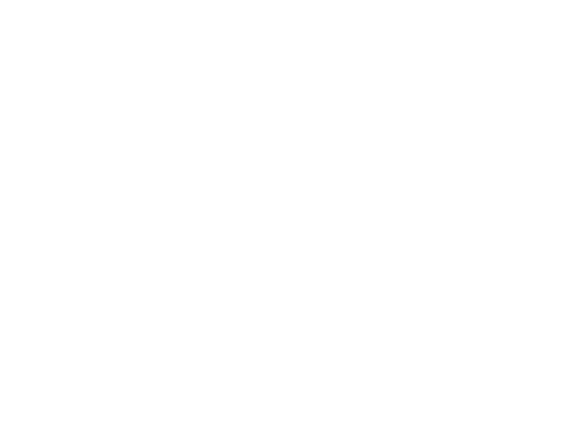

In [11]:
%matplotlib notebook

plt.imshow(im_ms, cmap='gray', vmin=100, vmax=150)

In [12]:
ms_intensity = dilation(cell_object_info[0]) * im_ms
ms_intensity_filtered = ms_intensity[ms_intensity!=0]
ms_positive_th =np.mean(ms_intensity_filtered) + np.std(ms_intensity_filtered)*3

ms_mask = (im_ms > ms_positive_th)*cell_object_info[0]
ms_mask = dilation(ms_mask)
ms_mask = remove_small_objects(ms_mask, 15)

<IPython.core.display.Javascript object>


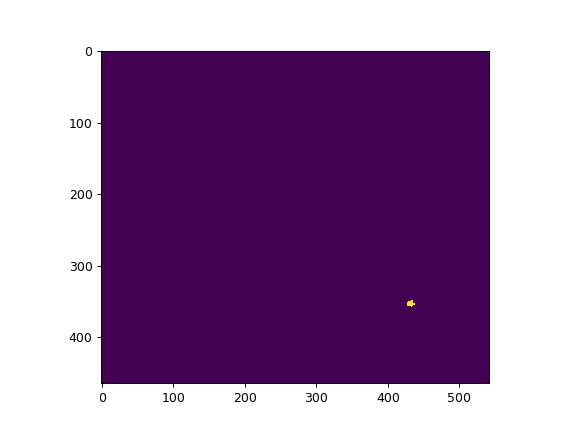

70

In [13]:
%matplotlib notebook

plt.imshow(ms_mask)

np.sum(ms_mask)

In [14]:
all_measurement_timed

{'1': 2.4091792821614395,
 '2': 2.752145205319962,
 '3': 2.2224667048396785,
 '4': 1.8344652382573403,
 '5': 3.045683389446203,
 '6': 2.7737176849611562,
 '7': 2.699534804952262,
 '8': 4.88581967022616,
 '9': 4.1626391459007115,
 '10': 4.51906507907161,
 '11': 6.486965094693344,
 '12': 6.544585736237516,
 '13': 5.970973573803865,
 '14': 5.46026300790084,
 '15': 4.597404946689761,
 '16': 'mitosis',
 '17': 'mitosis',
 '18': 'mitosis',
 '19': 'mitosis',
 '20': 0.7763745331761654,
 '21': 0.6980701680079382,
 '22': 'no',
 '23': 0.54279220947026,
 '24': 0.47751560188476944,
 '25': 0.6140651536527674,
 '26': 0.18506201586200033,
 '27': 1.5507168683745147,
 '28': 'no',
 '29': 'no',
 '30': 'yes_7.36464866358505',
 '31': 'no',
 '32': 'no',
 '33': 'yes_7.702012986422107',
 '34': 'no',
 '35': 'no',
 '36': 'yes_9.653298164945232',
 '37': 'no',
 '38': 'no',
 '39': 'no',
 '40': 'yes_8.198554824235936',
 '41': 'yes_7.863786361841678',
 '42': 'yes_8.570990924074549',
 '43': 'yes_8.069714866234333',
 '4

In [15]:
# save measurements as simple excel

df = pd.DataFrame(all_measurement_timed,index=[0])

df.to_excel(data_main_folder + os.sep + f'{data_name}_analysis_{cell_name}.xlsx', index=False)